<a href="https://colab.research.google.com/github/NIHALGOUR/project/blob/master/Copy_of_pavement_assessment_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload() 

# New Section

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json 

kaggle.json


In [ ]:
!kaggle datasets download -d atulyakumar98/pothole-detection-dataset

 95% 185M/194M [00:02<00:00, 63.4MB/s]
100% 194M/194M [00:03<00:00, 67.3MB/s]


In [ ]:
#importing the important libraries
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from shutil import copyfile


In [ ]:
#Unzipping the data to local tmp directory
local_zip = '/content/pothole-detection-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/unzipped_data')
zip_ref.close()

In [ ]:
#Creating the directories for the traning and testing 

try:
    os.mkdir('/tmp/pothole-v-normal')
    os.mkdir('/tmp/pothole-v-normal/training')
    os.mkdir('/tmp/pothole-v-normal/testing')
    os.mkdir('/tmp/pothole-v-normal/training/normal')
    os.mkdir('/tmp/pothole-v-normal/training/pothole')
    os.mkdir('/tmp/pothole-v-normal/testing/normal')
    os.mkdir('/tmp/pothole-v-normal/testing/pothole')
except OSError:
    print("Exception")
    pass

In [ ]:
#Spliting the data into training and testing

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


NORMAL_SOURCE_DIR = "/tmp/unzipped_data/normal/"
TRAINING_NORMAL_DIR = "/tmp/pothole-v-normal/training/normal/"
TESTING_NORMAL_DIR = "/tmp/pothole-v-normal/testing/normal/"
POTHOLE_SOURCE_DIR = "/tmp/unzipped_data/potholes/"
TRAINING_POTHOLE_DIR = "/tmp/pothole-v-normal/training/pothole/"
TESTING_POTHOLE_DIR = "/tmp/pothole-v-normal/testing/pothole/"

split_size = .95
split_data(NORMAL_SOURCE_DIR, TRAINING_NORMAL_DIR, TESTING_NORMAL_DIR, split_size)
split_data(POTHOLE_SOURCE_DIR, TRAINING_POTHOLE_DIR, TESTING_POTHOLE_DIR, split_size)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
#Downloding the weights of the inception V3

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (250, 250, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-04-24 20:08:11--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   120MB/s    in 0.7s    

2020-04-24 20:08:12 (120 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                             

In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Conv2D(64,(3,3),activation='relu')(last_output)

x = layers.Dropout(0.2)(x)  

x = layers.MaxPool2D(2,2)(x)

x = layers.Flatten()(x)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dropout(0.2)(x)                  

x = layers.Dense(1, activation='sigmoid')(x)           

model2= Model(pre_trained_model.input, x) 

model2.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

model2.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 124, 124, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 124, 124, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
base_dir = '/tmp/pothole-v-normal'
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'testing')


train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=0.2,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(250, 250),  
        batch_size=32,
        class_mode='binary')


validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(250, 250),
        batch_size=10,
        class_mode='binary')

history = model2.fit_generator(
      train_generator,
      steps_per_epoch=5, 
      epochs=50,
      validation_data=validation_generator,
      validation_steps=15,
      verbose=2)



Found 646 images belonging to 2 classes.
Found 35 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
5/5 - 10s - loss: 0.6163 - acc: 0.6438 - val_loss: 0.6597 - val_acc: 0.5481
Epoch 2/50
5/5 - 9s - loss: 0.3962 - acc: 0.8375 - val_loss: 0.3819 - val_acc: 0.9185
Epoch 3/50
5/5 - 9s - loss: 0.2677 - acc: 0.9250 - val_loss: 0.2948 - val_acc: 0.9333
Epoch 4/50
5/5 - 9s - loss: 0.2624 - acc: 0.9125 - val_loss: 0.2748 - val_acc: 0.9111
Epoch 5/50
5/5 - 9s - loss: 0.1906 - acc: 0.9179 - val_loss: 0.3071 - val_acc: 0.9407
Epoch 6/50
5/5 - 9s - loss: 0.1067 - acc: 0.9875 - val_loss: 0.2344 - val_acc: 0.9185
Epoch 7/50
5/5 - 9s - loss: 0.0809 - acc: 0.9750 - val_loss: 0.1903 - val_acc: 0.9111
Epoch 8/50
5/5 - 9s - loss: 0.1426 - acc: 0.9375 - val_loss: 0.1760 - val_acc: 0.9259
Epoch 9/50
5/5 - 8s - loss: 0.2478 - acc: 0.8881 - val_loss: 0.2103 - val_acc: 0.9111
Epoch 10/50
5/5 - 9s - loss: 0.1364 - acc: 0.9625 - val_loss: 0.1817

In [ ]:
model2.save('/tmp/testing_model_first.h5')

In [ ]:
label_map = (train_generator.class_indices)
print(label_map)

{'normal': 0, 'pothole': 1}


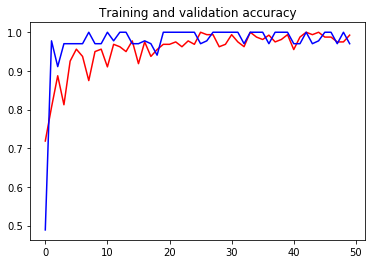

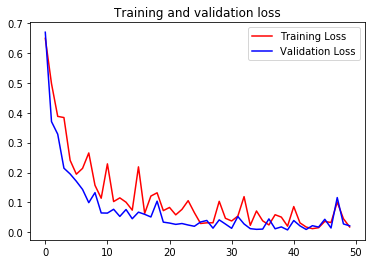

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files

uploaded = files.upload()

print(uploaded)
for fn in uploaded.keys():
  
  # print(fn)
  # # predicting images
  # path = fn
  # img = image.load_img(path, target_size=(250, 250))
  # x = image.img_to_array(img)
  # x = np.expand_dims(x, axis=0)

  # images = np.vstack([x])
  # classes = model2.predict(images, batch_size=6)
  # print(fn)
  # # if(classes[0][0]>=0.5):
  # #   classes[0][0]=1
  # # else:
  # #   classes[0][0]=0
  # print(classes)